In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df=pd.read_excel("sdgs_topic modelling.xlsx")

C:\Users\daian\anaconda3\lib\site-packages\openpyxl\compat\numbers.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.float,


In [4]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
train, test= train_test_split(df,test_size=0.1, random_state=120)

In [5]:
df.head(2)

,Organization_Name,Organization_City,Organization_Country,Organization_Website,Organization Linkedin,Short_description,Organization_Industries,Investor,Type_investment,Long_description
0,Affect Therapeutics,New York,United States,https://www.affecttherapeutics.com/,https://www.linkedin.com/company/affect-therap...,Affect Therapeutics is using mobile technology...,Health Care,Acumen,SDGs,Affect is using digital technology to deliver ...
1,Level,Seattle,United States,https://www.levelgoals.com/,https://www.linkedin.com/company/joinlevel/,Redefining financial services to power microbu...,Financial Services,Acumen,SDGs,Level makes it easy for people to pay with the...


In [6]:
# Groupby: cutwise median
group = df[['Organization_Name', 'Organization_Country']].groupby('Organization_Country').count()
group

,Organization_Name
Organization_Country,
Albania,1
Algeria,3
Argentina,4
Australia,2
Austria,1
...,...
Uruguay,1
Vietnam,1
Zambia,2


In [7]:
train.shape

(1079, 10)

In [8]:
df["Organization_Country"].value_counts()

United States     456
India             227
United Kingdom     81
Kenya              37
China              37
                 ... 
Austria             1
Belgium             1
Vietnam             1
Botswana            1
spain               1
Name: Organization_Country, Length: 90, dtype: int64

In [9]:
df["Organization_Industries"].value_counts()

Financial Services                            164
Software                                       73
Health Care                                    69
Information Technology                         62
Education                                      58
                                             ... 
E-Commerce, E-Commerce Platforms, Shopping      1
Fashion                                         1
Entertainment                                   1
 Semiconductor                                  1
Healthcare                                      1
Name: Organization_Industries, Length: 212, dtype: int64

In [10]:
df["Organization_Industries"].value_counts(normalize=True)

Financial Services                            0.136781
Software                                      0.060884
Health Care                                   0.057548
Information Technology                        0.051710
Education                                     0.048374
                                                ...   
E-Commerce, E-Commerce Platforms, Shopping    0.000834
Fashion                                       0.000834
Entertainment                                 0.000834
 Semiconductor                                0.000834
Healthcare                                    0.000834
Name: Organization_Industries, Length: 212, dtype: float64

In [11]:
df["Organization_Country"].value_counts(normalize=True)

United States     0.380317
India             0.189324
United Kingdom    0.067556
Kenya             0.030859
China             0.030859
                    ...   
Austria           0.000834
Belgium           0.000834
Vietnam           0.000834
Botswana          0.000834
spain             0.000834
Name: Organization_Country, Length: 90, dtype: float64

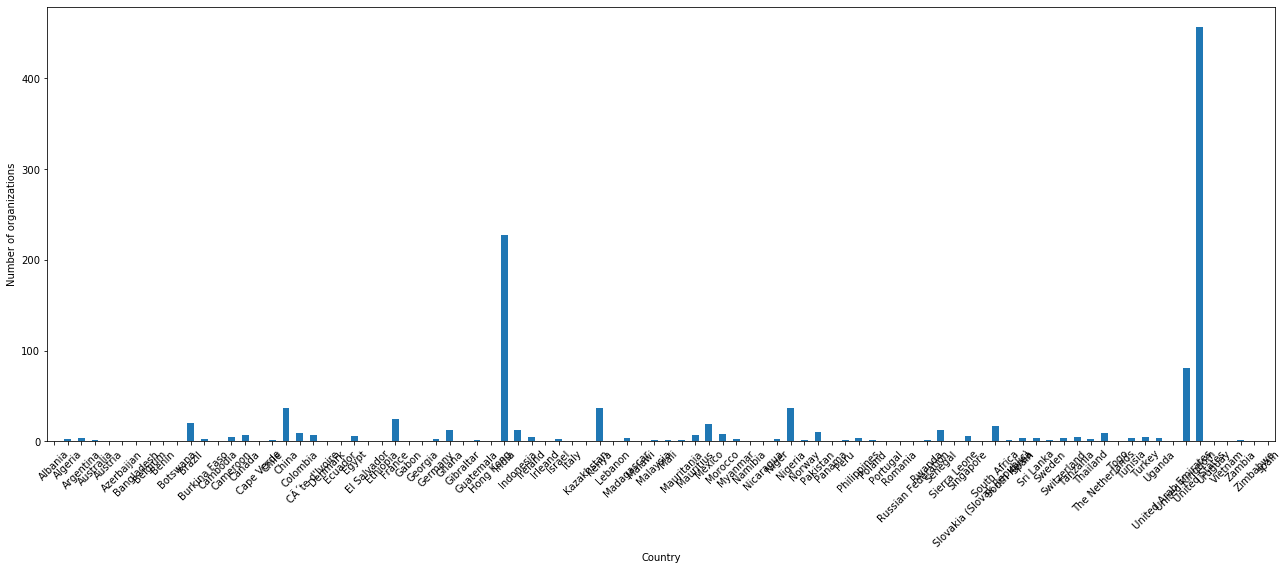

In [12]:
df["Organization_Name"].groupby(df["Organization_Country"]).count().plot(kind="bar",figsize=(22, 8),
                                           rot=45)
plt.xlabel("Country")
plt.ylabel("Number of organizations")
plt.show()
#plt.savefig('Charts\Hist3_'+'.png')

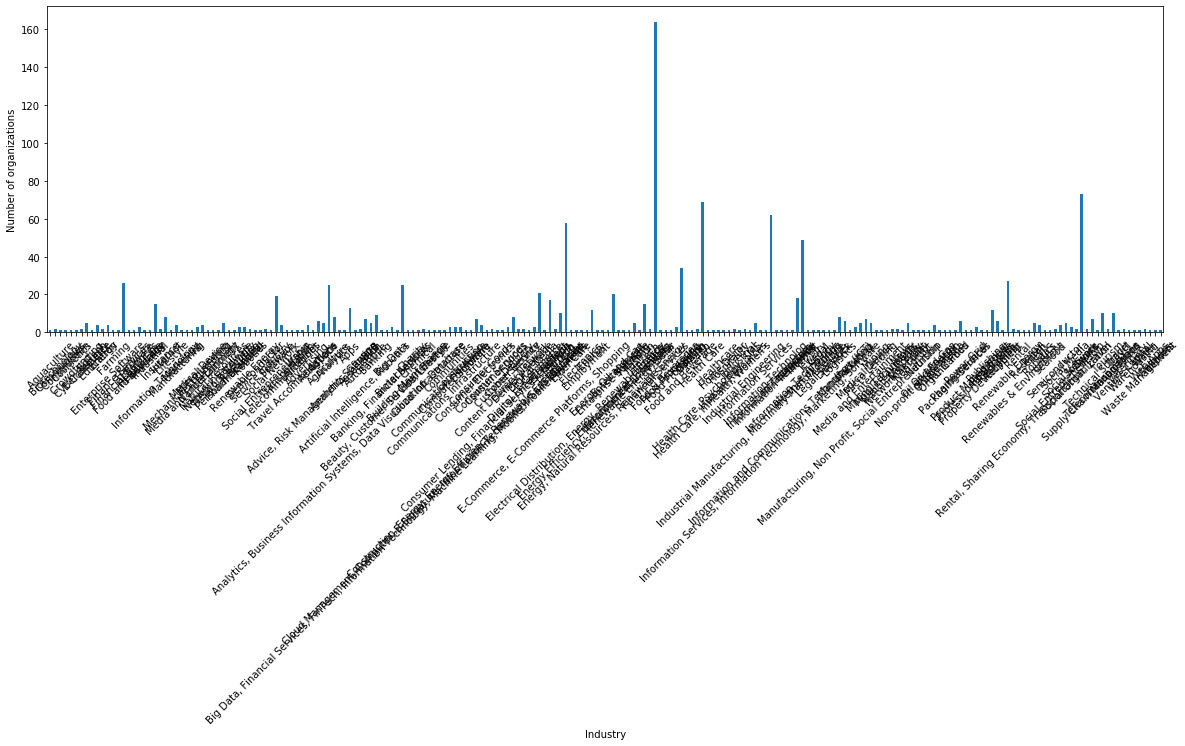

In [13]:
df["Organization_Name"].groupby(df["Organization_Industries"]).count().plot(kind="bar",figsize=(20, 6),
                                           rot=45)
plt.xlabel("Industry")
plt.ylabel("Number of organizations")
plt.show()
#plt.savefig('Charts\Hist2_'+'.png')

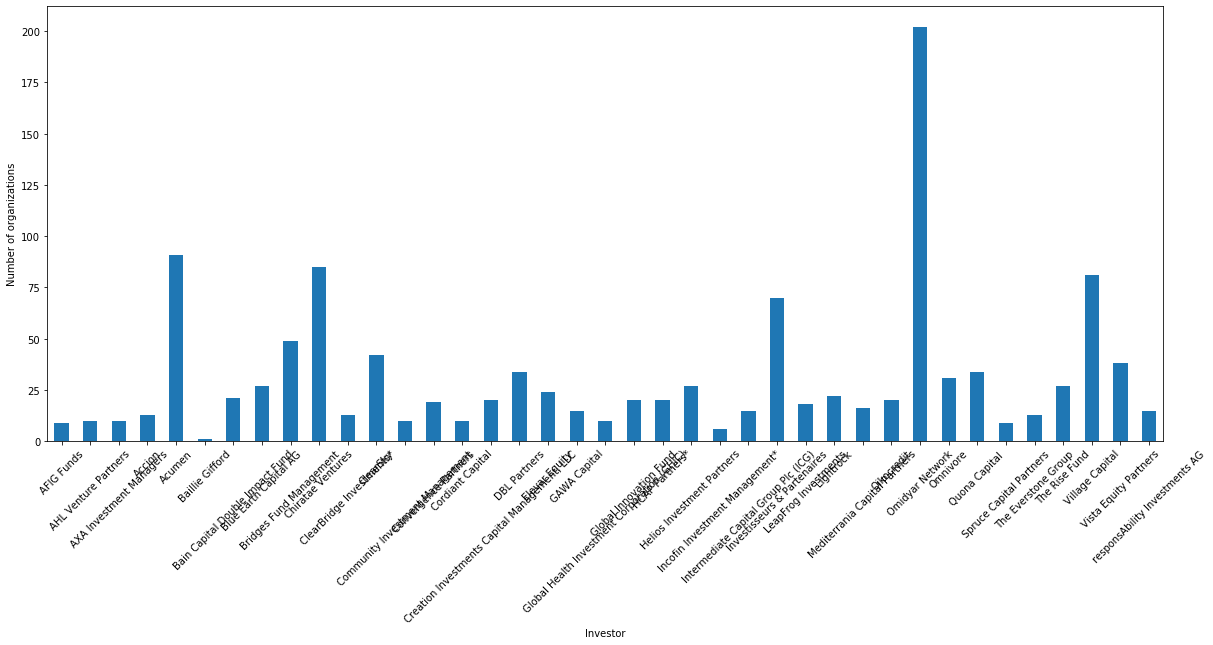

In [14]:
df["Organization_Name"].groupby(df["Investor"]).count().plot(kind="bar",figsize=(20, 8),
                                           rot=45)
plt.xlabel("Investor")
plt.ylabel("Number of organizations")
plt.show()
#plt.savefig('Charts\Hist_'+'.png')

In [15]:
train['NumWords'] = train['Long_description'].apply(lambda x: len(x.split()))

<>:3: DeprecationWarning: invalid escape sequence \H
<>:3: DeprecationWarning: invalid escape sequence \H
<>:3: DeprecationWarning: invalid escape sequence \H
<ipython-input-16-9f97d1875d46>:3: DeprecationWarning: invalid escape sequence \H
  plt.savefig('Charts\HistDistribWords_'+'.png')


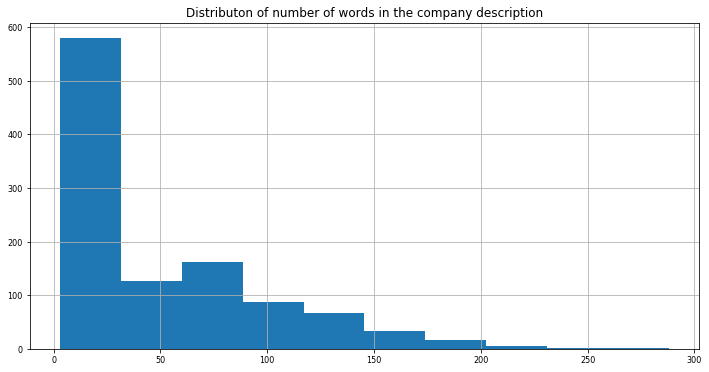

In [16]:
train[['NumWords']].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distributon of number of words in the company description")
plt.savefig('Charts\HistDistribWords_'+'.png')

<>:10: DeprecationWarning: invalid escape sequence \C
<>:10: DeprecationWarning: invalid escape sequence \C
<>:10: DeprecationWarning: invalid escape sequence \C
<ipython-input-19-d6b5e6f5f832>:10: DeprecationWarning: invalid escape sequence \C
  plt.savefig('Charts\Cloud_'+'.png')


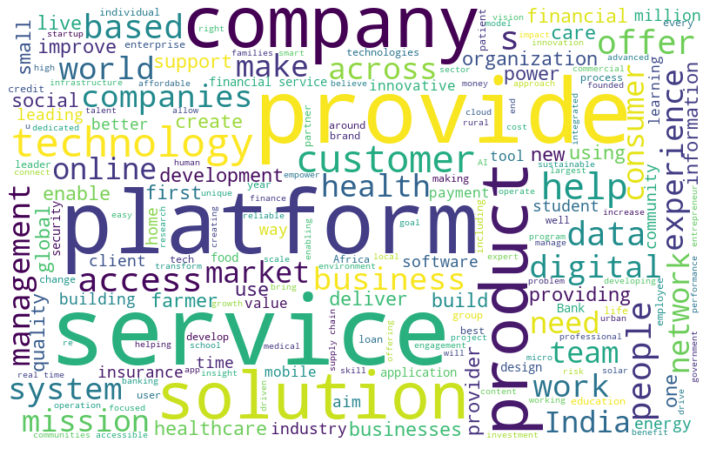

In [19]:
from wordcloud import WordCloud
all_words = ''.join([word for word in train['Long_description'][0:100000]])
all_words
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color="white").generate(all_words)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
#plt.title("Some frequent words used in the descriptions", weight='bold', fontsize=14)
#plt.show()
plt.savefig('Charts\Cloud_'+'.png')

In [20]:
# turn each word to the lowercase font, remove  punctuation

import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
  normalized_texts = ''
  lower = texts.lower()
  no_punctuation = NON_ALPHANUM.sub(r' ', lower)
  no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
  return no_non_ascii
  
train['Long_description'] = train['Long_description'].apply(normalize_texts)
train.head()
train['Long_description'] = train['Long_description'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

<>:22: DeprecationWarning: invalid escape sequence \T
<>:22: DeprecationWarning: invalid escape sequence \T
<>:22: DeprecationWarning: invalid escape sequence \T
<ipython-input-21-1372e4157aea>:22: DeprecationWarning: invalid escape sequence \T
  plt.savefig('Charts\TopWordsdescription_'+'.png')


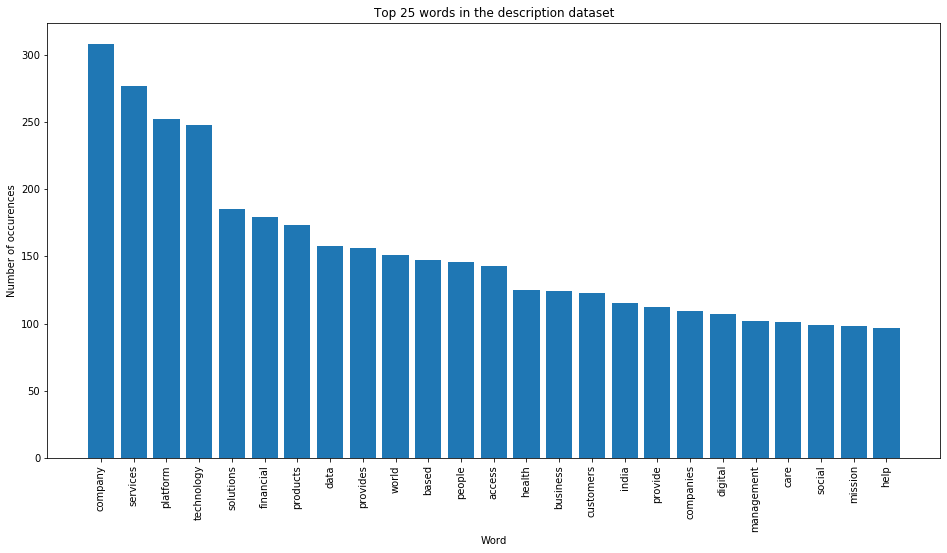

In [21]:
# top 25 words used with their frequencies.
def get_top_n_words(corpus, n=10):
  vec = CountVectorizer(stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]
words = []
word_values = []
for i,j in get_top_n_words(train['Long_description'],25):
  words.append(i)
  word_values.append(j)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 25 words in the description dataset');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
#plt.show()
plt.savefig('Charts\TopWordsdescription_'+'.png')

In [22]:
#convert to list
data=train.Long_description.values.tolist()

In [23]:
pprint(data[:1])

['lifespring mission grew out this deep deficiency and response women demand '
 'for alternative']


In [24]:
#tokenize and clean-up using gensim simple_preprocess()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])


[['lifespring', 'mission', 'grew', 'out', 'this', 'deep', 'deficiency', 'and', 'response', 'women', 'demand', 'for', 'alternative']]


In [25]:
#lemmatization - convert words to its root word

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out



In [26]:
# Initialize spacy 'en' model

nlp = spacy.load('en_core_web_sm')



In [27]:
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['lifespre mission grow deep deficiency response woman demand alternative', 'phandeeyar accelerator help most promising tech startup myanmar grow succeed']


In [28]:
#create the document word matrix
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum occurance of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of unique words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [29]:
#check sparcity - the percentge of non zero datapoints in the document word matrix 

data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.789074851441967 %


In [30]:
#build lda model with skleran

lda_model = LatentDirichletAllocation(n_components=8,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=8, n_jobs=-1,
                          random_state=100)


In [32]:
#diagnose model perfromance with perplexity and log likelihood
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())


Log Likelihood:  -133467.59368356987
Perplexity:  464.23622399379593
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 8,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [97]:
# Define Search Parameters
search_params = {'n_components': [5,8,10], 'learning_decay': [.5, .7, .9]}

# Initialize the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)


GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 8, 10]})

In [98]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -30011.582699113165
Model Perplexity:  428.0454113411657


<>:21: DeprecationWarning: invalid escape sequence \c
<>:21: DeprecationWarning: invalid escape sequence \c
<>:21: DeprecationWarning: invalid escape sequence \c
<ipython-input-36-74170256f57b>:21: DeprecationWarning: invalid escape sequence \c
  plt.savefig('Charts\choosing optimalLDAModel_'+'.png')


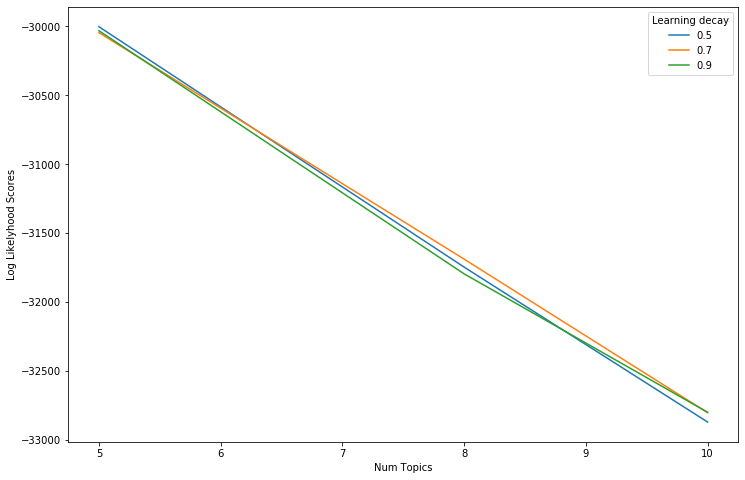

In [36]:
# Get Log Likelyhoods from Grid Search Output

from sklearn.model_selection import GridSearchCV
n_topics = [5,8,10]
#log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
#log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
#log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')

plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
#plt.show()
plt.savefig('Charts\choosing optimalLDAModel_'+'.png')

In [37]:
#see dominant topic in each document
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]



In [38]:
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.030000,0.030000,0.270000,0.030000,0.650000,4
Doc1,0.450000,0.040000,0.430000,0.040000,0.040000,0
Doc2,0.040000,0.040000,0.040000,0.840000,0.040000,3
Doc3,0.970000,0.010000,0.010000,0.010000,0.010000,0
Doc4,0.020000,0.020000,0.480000,0.450000,0.020000,2
Doc5,0.030000,0.030000,0.030000,0.470000,0.450000,3
Doc6,0.030000,0.130000,0.030000,0.030000,0.780000,4
Doc7,0.100000,0.100000,0.100000,0.590000,0.100000,3
Doc8,0.030000,0.900000,0.030000,0.030000,0.030000,1
Doc9,0.170000,0.020000,0.020000,0.770000,0.020000,3


In [39]:
df_document_topics.to_excel("skilearn_sdgs_topics.xlsx")

In [40]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,4,297
1,3,290
2,2,218
3,1,161
4,0,113


In [41]:
df_topic_distribution.to_excel("topic_distribution.xlsx")

In [43]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\daian\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\daian\AppData\Roaming\Python\Python37\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\Users\daian\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\daian\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\daian\anaconda3\lib\site-packages\sklearn\manifold\_t_sne

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      150.222153  -72.269554       1        1  28.588409
3       51.163364 -159.968018       2        1  23.891080
2      -73.144554   21.523815       3        1  22.720716
1      -66.410133 -110.606438       4        1  13.123355
0       54.417324   12.443444       5        1  11.676439, topic_info=          Term        Freq       Total Category  logprob  loglift
204  financial  176.000000  176.000000  Default  30.0000  30.0000
234     health  121.000000  121.000000  Default  29.0000  29.0000
237       help  191.000000  191.000000  Default  28.0000  28.0000
63        care  100.000000  100.000000  Default  27.0000  27.0000
67       chain   61.000000   61.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
249     impact   16.514042   57.786300   Topic5  -5.0349   0.8951
505   solution   19.071714  228.281551   Topic5  -4.8909  -0.3348
486    service   19.538982  363.402838   Topic5  -4.8667  -0.7755
90     company   18.843197  406.357704   Topic5  -4.9030  -0.9235
503   software   16.760232   77.268663   Topic5  -5.0201   0.6193

[306 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2         1  0.170360  access
2         2  0.482687  access
2         3  0.234245  access
2         4  0.063885  access
2         5  0.056787  access
...     ...       ...     ...
590       1  0.629052   world
590       2  0.127149   world
590       3  0.133841   world
590       4  0.026768   world
590       5  0.073612   world

[667 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 2, 1])

In [44]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

C:\Users\daian\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,able,accelerate,access,accessible,account,achieve,action,actionable,active,activity,...,win,woman,work,worker,workforce,world,worldwide,year,yield,young
Topic0,0.201075,4.984944,7.540745,5.907443,1.313808,9.347317,4.888343,6.283695,0.201565,0.205298,...,0.202659,0.509121,3.466785,2.248532,7.056251,11.414219,0.200080,1.317526,4.123878,8.692573
Topic1,0.204491,2.942267,9.337917,4.190122,0.209704,5.883149,4.652511,0.204371,2.598360,5.383602,...,1.246359,0.200546,6.598804,0.200611,0.204603,4.436788,6.215937,0.266434,0.200007,0.200579
Topic2,0.205106,4.884854,33.813827,0.208122,0.200048,8.095573,5.057150,0.208538,3.370568,3.986466,...,4.662638,18.007590,70.406715,11.147786,3.334006,20.583281,0.203156,21.272966,0.273066,16.515101
Topic3,13.352270,0.201838,69.768669,4.377080,12.067601,0.208172,0.200629,0.200463,1.471320,9.424874,...,0.215713,8.081113,16.560910,0.202635,0.202087,20.004378,0.203334,11.616311,2.662201,1.391038
Topic4,4.037058,6.986097,24.538842,17.317233,0.208840,4.465788,0.201367,6.102932,7.358186,3.999759,...,4.672630,0.201630,45.966786,0.200436,0.203053,97.561334,8.177492,24.526763,5.740848,0.200709


In [45]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=17)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

C:\Users\daian\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16
Topic 0,help,platform,chain,business,supply,farmer,technology,build,talent,enable,value,engagement,use,create,information,provide,manage
Topic 1,solution,service,provide,technology,company,social,management,client,offer,security,digital,community,platform,government,development,business,organization
Topic 2,health,care,technology,healthcare,company,provide,work,patient,support,solution,service,people,life,improve,develop,medical,need
Topic 3,financial,service,company,provide,product,finance,india,small,business,access,bank,credit,loan,payment,customer,offer,market
Topic 4,company,platform,world,use,make,datum,product,technology,power,build,energy,customer,service,base,provide,time,real


In [46]:
df_topic_keywords.to_excel("df_topic_keywords.xlsx")

In [47]:
data_test=test.Long_description.values.tolist()

In [65]:
data_test[:1]

['Sempli is the leading online lending platform for small businesses in Colombia.']

In [58]:
#predict topic for a new piece of text
# Define function to predict topic for a given text document.

nlp = spacy.load('en_core_web_sm')

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores



In [66]:
# Predict the topic
mytext = ["Sempli is the leading online lending platform for small businesses in Colombia."]
topic, prob_scores = predict_topic(text = mytext)
print(topic)
#allocated to topic 3

['financial', 'service', 'company', 'provide', 'product', 'finance', 'india', 'small', 'business', 'access', 'bank', 'credit', 'loan', 'payment', 'customer', 'offer', 'market']


In [72]:
# Predict the topic
mytext = ["eradicate extreme poverty for all people everywhere"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)
#allocated to topic 2

['health', 'care', 'technology', 'healthcare', 'company', 'provide', 'work', 'patient', 'support', 'solution', 'service', 'people', 'life', 'improve', 'develop', 'medical', 'need']


In [116]:
# Predict the topic
mytext = ["solar renewable"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)
#allocated to topic 2

['financial', 'service', 'company', 'provide', 'product', 'finance', 'india', 'small', 'business', 'access', 'bank', 'credit', 'loan', 'payment', 'customer', 'offer', 'market']


In [117]:
# Predict the topic
mytext = ["educate"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)
#allocated to topic 2

['help', 'platform', 'chain', 'business', 'supply', 'farmer', 'technology', 'build', 'talent', 'enable', 'value', 'engagement', 'use', 'create', 'information', 'provide', 'manage']


In [118]:
# Predict the topic
mytext = ["farmer agriculture "]
topic, prob_scores = predict_topic(text = mytext)
print(topic)
#allocated to topic 2

['company', 'platform', 'world', 'use', 'make', 'datum', 'product', 'technology', 'power', 'build', 'energy', 'customer', 'service', 'base', 'provide', 'time', 'real']


# 
Cluster documents that share similar topics and plot



In [67]:
#cluster documents that share similar topics 
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=5, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.17  0.24  0.35  0.57  0.68]
 [ 0.03  0.03  0.07  0.73 -0.68]]
Perc of Variance Explained: 
 [0.04 0.36]


C:\Users\daian\anaconda3\lib\site-packages\scipy\linalg\decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
C:\Users\daian\anaconda3\lib\site-packages\scipy\linalg\decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current

# We have the X, Y and the cluster number for each document.

Plot the document along the two SVD decomposed components. The color of points represents the cluster number (in this case) or topic number.

<>:7: DeprecationWarning: invalid escape sequence \c
<>:7: DeprecationWarning: invalid escape sequence \c
<>:7: DeprecationWarning: invalid escape sequence \c
<ipython-input-68-1b2a4f734385>:7: DeprecationWarning: invalid escape sequence \c
  plt.savefig('Charts\clusterdocuments_'+'.png')


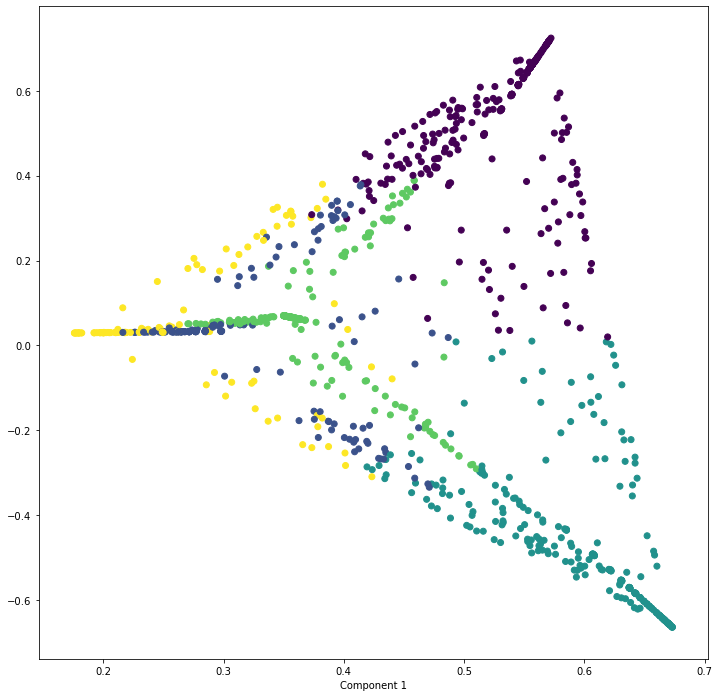

In [68]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')

plt.savefig('Charts\clusterdocuments_'+'.png')

#  Get similar documents for any given piece of text
Once you know the probaility of topics for a given document (using predict_topic()), compute the euclidean distance with the probability scores of all other documents.

The most similar documents are the ones with the smallest distance.

In [70]:
from sklearn.metrics.pairwise import euclidean_distances


nlp = spacy.load("en_core_web_sm")

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Probability Scores of text: ", np.round(x, 1))
        print("Most Similar Documents's Probabilities:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [83]:
# Get similar documents
mytext = ["hunger"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:1200])

Topic KeyWords:  ['help', 'platform', 'chain', 'business', 'supply', 'farmer', 'technology', 'build', 'talent', 'enable', 'value', 'engagement', 'use', 'create', 'information', 'provide', 'manage']
Topic Probability Scores of text:  [[0.2 0.2 0.2 0.2 0.2]]
Most Similar Documents's Probabilities:   [[0.2 0.2 0.2 0.2 0.2]]

 the organic sea cucumber madagascar sandfish holothuria scabra


In [86]:
# Get similar documents
mytext = ["reduce poverty"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:1200])

Topic KeyWords:  ['health', 'care', 'technology', 'healthcare', 'company', 'provide', 'work', 'patient', 'support', 'solution', 'service', 'people', 'life', 'improve', 'develop', 'medical', 'need']
Topic Probability Scores of text:  [[0.1 0.1 0.7 0.1 0.1]]
Most Similar Documents's Probabilities:   [[0.1 0.1 0.7 0.1 0.1]]

 alina homecare passionately believes top quality reassuring homecare


In [88]:
# Get similar documents
mytext = ["Ensure healthy lives and promote well-being "]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:1200])

Topic KeyWords:  ['health', 'care', 'technology', 'healthcare', 'company', 'provide', 'work', 'patient', 'support', 'solution', 'service', 'people', 'life', 'improve', 'develop', 'medical', 'need']
Topic Probability Scores of text:  [[0.  0.  0.8 0.  0. ]]
Most Similar Documents's Probabilities:   [[0.  0.  0.8 0.  0. ]]

 colaser ophthalmologic clinic that aims respond the needs the clientele under healthcare programs


In [115]:
# Get similar documents
mytext = ["renewable  "]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:1200])

Topic KeyWords:  ['financial', 'service', 'company', 'provide', 'product', 'finance', 'india', 'small', 'business', 'access', 'bank', 'credit', 'loan', 'payment', 'customer', 'offer', 'market']
Topic Probability Scores of text:  [[0.1 0.1 0.1 0.6 0.1]]
Most Similar Documents's Probabilities:   [[0.1 0.1 0.1 0.6 0.1]]

 reelfruit fruit agribusiness nigeria
